# WEB-SCI Coursework Q1
### By Isaac Tabb

First, let's begin by importing the geoLondonJan23.json dataset.

In [ ]:
# import json
import json

# create a list to hold all of the json objects
json_list = []
# open the file
with open('geoLondonJan23.json') as f:
    # iterate through each line in the file
    for line in f:
        # load an append to list
        dct = json.loads(line)
        json_list.append(dct)

print(json_list[1])

{'_id': 1617627087447154696, 'date': {'$date': '2023-01-23T20:55:26Z'}, 'screen_name': 'thedukeldn', 'qualityScore': 0.6655813953488372, 'text': 'Just getting warmed up   @ London, United Kingdom https://t.co/584EtfV0Xy', 'url': 'https://t.co/E2DsKwJRJJ', 'description': 'Luke Kenneth Andrew Lentes.\nA creative mind with multiple outlets.\nBased in London. Available worldwide.\nMaking an Elephant 🐘', 'listed_count': 1, 'user_created': {'$date': '2020-11-10T12:42:42Z'}, 'geo_enabled': True, 'favourites_count': 640, 'coordinates': [-0.1094, 51.5141], 'location': 'London, England', 'followers_count': 70, ' friends_count': 70, 'place_name': 'City of London, London', 'place_country': 'United Kingdom', 'country_code': 'GB', 'place_coordinates': [[[-0.112442, 51.5068], [-0.0733794, 51.5068], [-0.0733794, 51.522161], [-0.112442, 51.522161]]], 'hashtags': [], 'mentions': [], 'source': 'Instagram'}


## Sorting the Tweets into Grid Boxes

Next, let's define the London bounding box.

In [ ]:
# define the London bounding box
bnd_box = {
    "top_right": [51.686031, 0.28036],
    "top_left": [51.686031, -0.563],
    "bottom_right": [51.261318, 0.28036],
    "bottom_left": [51.261318, -0.563]
    }

We will need to compute the distance between coordinates so I will define a function to compute the Haversine Distance.

In [ ]:
import math
# function to compute the distance between two points on a sphere
def compute_distance(coords):
    R = 6373.0
    # initialize the latitudes and longitudes as the corresponding coordinates
    lat1 = coords[1]
    long1 = coords[0]
    lat2 = coords[3]
    long2 = coords[2]

    # use haversine's formula to calculate the distance
    phi1 = lat1 * (math.pi/180)
    phi2 = lat2 * (math.pi/180)
    delta1 = (lat2-lat1) * (math.pi/180)
    delta2 = (long2-long1) * (math.pi/180)
    a = math.sin(delta1/2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta2/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c

    # return the distance (on sphere)
    return d

Let's first use the distance function to find the height and width (in km) of the London bounding box.

In [ ]:
# compute height of bounding box
height = compute_distance([bnd_box['top_right'][1],bnd_box['top_right'][0],
                          bnd_box['bottom_right'][1],bnd_box['bottom_right'][0]])

# compute width of bounding box
width = compute_distance([bnd_box['top_right'][1],bnd_box['top_right'][0],
                         bnd_box['top_left'][1],bnd_box['top_left'][0]])

And following that, we can compute the total # of grid boxes.

In [ ]:
# multiply together for squared km, since the grid is 1kmx1km, this value is the # of boxes
num_of_grids = round(height) * round(width)

The height of the bounding box is 47.241 km while the width is 58.157 km. We will round these values to 47 km and 58 km to ensure all boxes are exactly 1km x 1km. This gives us 2726 total 1km x 1km grid boxes.

Now we will need a function which assigns each tweet to a grid box based on its coordinates.

In [ ]:
# function which takes in a tweet and the london bounding box
# calculates which grid box the tweet belongs in 
def calculate_grid_box(tweet, bnd_box):
    # takes the coordinates of the tweet
    coords = tweet['coordinates']
    # calculates the distance width-wise from the top left corner of london bnd box
    dist_width = compute_distance([bnd_box['top_left'][1], bnd_box['top_left'][0],
                                   coords[0], bnd_box['top_left'][0]])
    # calculates the distance height-wise from the top left corner of london bnd box
    dist_height = compute_distance([bnd_box['top_left'][1], bnd_box['top_left'][0],
                                   bnd_box['top_left'][1], coords[1]])
    # adds a new part to the json dictionary, the grid box of the tweet
    tweet['grid_box'] = [math.floor(dist_height), math.floor(dist_width)]

Let's iterate through the tweets list and assign each.

In [ ]:
# iterates through each tweet, calculating grid box
for tweet in json_list:
    calculate_grid_box(tweet, bnd_box)

## Analyzing the Statistics

Now, let's create a dictionary which stores the tweets in their corresponding grid box.

In [ ]:
# create dictionary of grid boxes
grid_boxes = {}
# iterate over height
for i in range(47):
    # iterate over weight
    for j in range(58):
        grid_boxes[(i,j)] = []

# for each tweet, add to corresponding grid box list in grid_boxes dictionary
for tweet in json_list:
    height = tweet['grid_box'][0]
    width = tweet['grid_box'][1]
    grid_boxes[(height, width)].append(tweet)

And here is another useful dictionary which stores the size of each grid box.

In [ ]:
# create a dictionary to store sizes of each box
# this will be a helpful dictionary when looking at the distribution of tweets
grid_sizes = {}
for grid in grid_boxes:
    grid_sizes[grid] = len(grid_boxes.get(grid))

Let's look at the total number of tweets along with the most common grid boxes.

In [ ]:
# use counter to find top 10 most common for report
from collections import Counter
top10_areas = dict(Counter(grid_sizes).most_common(10))

# calculate the total tweets number of tweets
total_tweets = len(json_list)
print(total_tweets)

10526


In [ ]:
# output the top 10 grid boxes
top10_areas

{(19, 31): 3605,
 (19, 30): 981,
 (19, 29): 564,
 (23, 33): 479,
 (19, 32): 401,
 (20, 30): 186,
 (19, 28): 168,
 (21, 34): 150,
 (18, 30): 135,
 (18, 28): 128}

We can see here that there are a total of 10526 tweets in the dataset and 3605 of them are from the (19, 31) box.

Let's also look a little bit at the distribution. For instance, how many tweets are within 3 boxes of the hottest box (19, 31)?

In [ ]:
# calculate the number of tweets in the center of london 
# (between box 17-23 height-wise, between box 28-34 width-wise)
tweets_in_center = 0
for i in range(16,23):
    for j in range(28,35):
        tweets_in_center += grid_sizes.get((i,j))

print(tweets_in_center)
print(tweets_in_center/total_tweets)

7984
0.7585027550826525


We see here that 7984 tweets are within 3 boxes of the most popular boxes. That is 75.9% of all of the tweets in the dataset.

Let's find a little more information about distribution. Read the comments below to see what the following code does.

In [ ]:
# Obtain distribution centered around the hottest grid box (19,31)
# The distribution will be in rings
#   1. The first ring is the hottest grid box (19,31)
#   2. The second ring includes grid boxes within 1 row or 1 column of (19,31)
#       ex. (18, 30)  (18, 31)  (18, 32)
#           (19, 30)            (19, 32)
#           (20, 30)  (20, 31)  (20, 32)
#       Note: Ring 2 does not include (19,31)
#   3. The third ring follows the same pattern and so on...
#   Note: Rings 20-31 only expand column wise since the bounding box of London
#         is wider than it is tall.

# dictionary to hold the ring counts
distribution = {}
# intiialize the rings of the distribution
for i in range(32):
    distribution[i] = 0

center_h = 19
center_w = 31
for tweet in json_list:
    # calculate the ring which the tweet is located in
    ring = max(abs(tweet['grid_box'][0]-center_h),abs(tweet['grid_box'][1]-center_w))
    # increment that ring in the dictionary
    distribution[ring] += 1

In [ ]:
distribution

{0: 3605,
 1: 2025,
 2: 1448,
 3: 906,
 4: 911,
 5: 539,
 6: 289,
 7: 198,
 8: 237,
 9: 105,
 10: 71,
 11: 19,
 12: 28,
 13: 59,
 14: 12,
 15: 49,
 16: 25,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0}

We can learn a lot from this distribution. For instance, not a single tweet in the dataset is from beyond the 17th ring. Additionally, 89.6% of the data is within 5 grid boxes of (19, 31).

## Data Visualization

#### Creating a Heat Map

To get a good feel for the distribution of the data, let's create some visualizations. We'll create a heatmap and a bar graph.

Before we create a heatmap, we need to make sure the data is formatted correctly.

In [ ]:
import pandas as pd
# create empty dataframe with columns row, col, and value
tweets_df = pd.DataFrame(columns=["Row", "Col", "Value"])

# iterate through grid_sizes, filling dataframe
for tweet in grid_sizes:
  new_row = {"Row":int(tweet[0]), "Col":int(tweet[1]), "Value":int(grid_sizes[tweet])}
  tweets_df = tweets_df.append(new_row, ignore_index=True)

# pivot the dataframe so it is the correct format for heatmap
tweets_df = tweets_df.astype(float)
tweets_df_pivoted = tweets_df.pivot('Row', 'Col', 'Value')

Now, let's make the heat map.

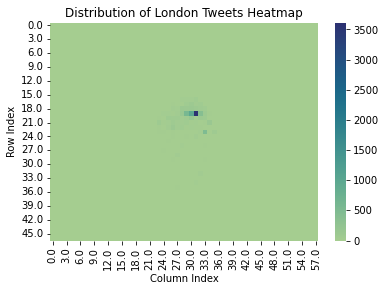

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# create seaborn heatmap
sns.heatmap(tweets_df_pivoted, cmap="crest")
plt.ylabel("Row Index")
plt.xlabel("Column Index")
plt.title("Distribution of London Tweets Heatmap")
plt.savefig('londontweetsheatmap.png', bbox_inches='tight')
plt.show()

As you can see, there's not much going on other than right in the center, so let's make a zoomed in heat map on that center to get a better picture.

Let's subset the tweets dataframe.

In [ ]:
# we will subset the dataframe to only tweets within 10 grid boxes of the hottest box (19, 31)
tweets_df_subset = tweets_df[(tweets_df["Col"] < 41) & (tweets_df["Col"] > 21) & (tweets_df["Row"] < 29) & (tweets_df["Row"] > 9)]
tweets_df_subset_pivoted = tweets_df_subset.pivot('Row', 'Col', 'Value')

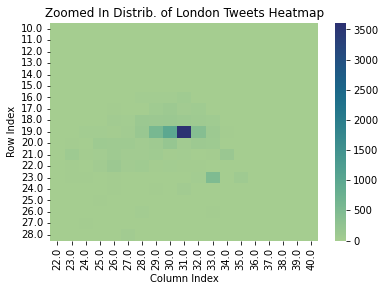

In [ ]:
sns.heatmap(tweets_df_subset_pivoted, cmap="crest")
plt.ylabel("Row Index")
plt.xlabel("Column Index")
plt.title("Zoomed In Distrib. of London Tweets Heatmap")
plt.savefig('zommedlondontweetsheatmap.png', bbox_inches='tight')
plt.show()

### Looking into the [-0.1094, 51.5141] Coordinate

As we can see from the heatmap, a very large number of tweets are from that center box and not many are from any other boxes. So why are so many tweets from this box? Many of the tweets have the coordinate [-0.1094, 51.5141]. But how many is many?

In [ ]:
count_of_coord = 0
count_of_insta = 0
# iterate through the tweets in the (19, 31) box
for tweet in grid_boxes[(19,31)]:
  # if the tweet is at the specific coordinates, increment count
  if tweet['coordinates'] == [-0.1094, 51.5141]:
    count_of_coord += 1
    # if the tweet is at those coords and from instagram, increment count
    if tweet['source'] == 'Instagram':
      count_of_insta += 1

print("Tweets in (19, 31) at [-0.1094, 51.5141]: " + str(count_of_coord))
print("Proportion of (19, 31) tweets at [-0.1094, 51.5141]: " + str(round(count_of_coord/(grid_sizes[(19,31)]), 2)))

print("Tweets from Instagram at [-0.1094, 51.5141]: " + str(count_of_insta))

Tweets in (19, 31) at [-0.1094, 51.5141]: 3527
Proportion of (19, 31) tweets at [-0.1094, 51.5141]: 0.98
Tweets from Instagram at [-0.1094, 51.5141]: 3527


For some reason, nearly all of the tweets are from that exact coordinate. This might have something to do with the source they all come from though, Instagram.

Noting that the sources from (19, 31) are mostly from Instagram, let's look at the sources for all of the tweets across the entire dataset.

In [ ]:
client_apps = []
for tweet in json_list:
  # add to the source of the tweet to the client app list
  client_apps.append(tweet['source'])

Counter(client_apps)

Counter({'Instagram': 8019,
         'everybot': 309,
         'Untappd': 157,
         'Foursquare': 400,
         'CareerArc 2.0': 1083,
         'Foursquare Swarm': 176,
         'Hootsuite Inc.': 17,
         'dlvr.it': 251,
         'Squarespace': 47,
         'Landmark Manager Web': 2,
         'World Flags': 3,
         'FL': 6,
         'Wikishire': 8,
         'Leading Restaurants': 2,
         'Estate Agent Feeds': 3,
         'Tweetbot for iΟS': 5,
         '#Träwelling': 3,
         'BLUF.com': 2,
         'citydescriber': 2,
         'Hackney-a-la-mode': 5,
         'Good Stuff Tweeter': 1,
         'I Heart Locations': 4,
         "edent's Tweeting Robot": 3,
         'LuxuryRealEstate.com': 1,
         'TweetCaster for Android': 3,
         'trendsmetadata': 3,
         'Liveuamap': 1,
         'Brooklyn à la mode': 3,
         'narrowbotR': 1,
         'Twitter for iPhone': 1,
         'trainlogger': 4,
         'Fenix 2': 1})

We can see here that the sources from the dataset are basically never Twitter. The vast majority of tweets are from Instagram, some are also from CareerArc2.0. Only one tweet is from Twitter for iPhone.

### Creating a Histogram

Now let's create a histogram which plots the number of grids by number of tweets. In other words, how many grid boxes of each size?

Let's turn the grid totals into a list.

In [ ]:
grid_totals_list = tweets_df['Value'].tolist()

And now let's plot that list as a histogram.

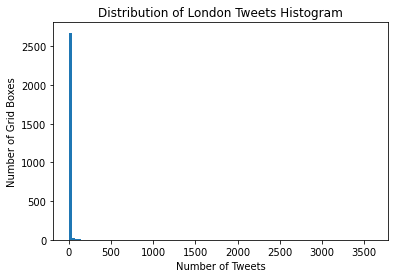

In [ ]:
plt.hist(grid_totals_list, bins=100)
plt.ylabel("Number of Grid Boxes")
plt.xlabel("Number of Tweets")
plt.title("Distribution of London Tweets Histogram")
plt.show()

It's kind of hard to interpret the first graph so let's use a logarithmic y-axis.

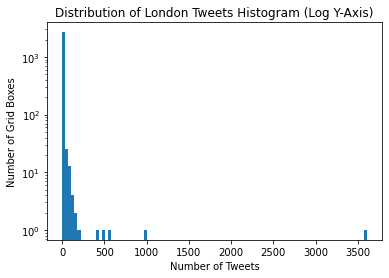

In [ ]:
plt.hist(grid_totals_list, bins=100, log=True)
plt.ylabel("Number of Grid Boxes")
plt.xlabel("Number of Tweets")
plt.title("Distribution of London Tweets Histogram (Log Y-Axis)")
plt.savefig('distlondontweetslog.png')
plt.show()

As we can see from this figure, a very large number of grid boxes have 0 tweets in them. Then there is the (19, 31) box which has over 3500. The data is not very spread out.